In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [49]:
df = pd.read_excel("STOXX - kopie.xlsx",index_col='Date',parse_dates=True)

In [50]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [51]:
df.head()

,ds,wasserstein_dists_2D,y,VIX,unique_id
0,2004-05-25,0.047309,0.005405,15.960000,airplane1
1,2004-05-26,0.043802,0.006130,15.970000,airplane1
2,2004-05-27,0.051132,0.005242,15.280000,airplane1
3,2004-05-28,0.047027,0.005190,15.500000,airplane1
4,2004-06-01,0.041049,0.005470,16.299999,airplane1


In [6]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 93112870


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 28957817


Epoch: 350 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.004046602181898629 | QLIKE: 0.12020912637593592


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58816447


Epoch: 750 | Inputs: 5 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.004897929135647638 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101292766


Epoch: 100 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.004268905583390502 | QLIKE: 0.15063387682433405


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 32327912


Epoch: 100 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.004290644431672056 | QLIKE: 0.15451413018748905


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 50 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.00445661476512613 | QLIKE: 0.17158952544128642


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 45324691


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40435182


Epoch: 450 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.004027920807564473 | QLIKE: 0.12145212645649442


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 36551135


Epoch: 25 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.004551627261463518 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60876346


Epoch: 550 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.004123393810485902 | QLIKE: 0.12414533170163104


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 52226860


Epoch: 50 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.004147396436507979 | QLIKE: 0.12878078494617898


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.00412153693084373 | QLIKE: 0.12854230869806318


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 127143924


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 107870644


Epoch: 250 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.004454209772048351 | QLIKE: 0.1701068022072611


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98253958


Epoch: 750 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0040679380251219845 | QLIKE: 0.13578110316900038


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 72515555


Epoch: 750 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0040000423921876605 | QLIKE: 0.12340177338722919


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13636226


Epoch: 450 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.004160724261357835 | QLIKE: 0.13110621071944398


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 550 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0039359370502323335 | QLIKE: 0.11777746153931895


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 102633955


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56254222


Epoch: 750 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.004167558054582269 | QLIKE: 0.13950320669426952


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5622390


Epoch: 150 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.004519560481610749 | QLIKE: 0.20891517575130522


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 108279269


Epoch: 100 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.003990120872191528 | QLIKE: 0.11988504052419591


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60913215


Epoch: 25 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.004382886444041741 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.004457124790718061 | QLIKE: 0.1715274978684635


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 43362561


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 105701998


Epoch: 100 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0039021318345916216 | QLIKE: 0.11534332658124882


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 112217691


Epoch: 25 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.004507401942175227 | QLIKE: 0.19048707180300842


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31605727


Epoch: 250 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 1 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.004229911930695136 | QLIKE: 0.6211259487813324


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110667820


Epoch: 750 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.004221339564497606 | QLIKE: 0.1420681483840048


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 50 | Inputs: 10 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.00409784081863328 | QLIKE: 0.1358473798895909


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 25335184


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16515231


Epoch: 50 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.004449472403256444 | QLIKE: 0.18594156670519374


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3584821


Epoch: 25 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.004477930817368374 | QLIKE: 0.18746847344953552


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13600684


Epoch: 100 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.004360200481016278 | QLIKE: 0.16241575703712188


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 106930664


Epoch: 250 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.004416945514094421 | QLIKE: 0.22828990001133562


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.003968518010555225 | QLIKE: 0.12718157773534566


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 33124352


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 73818362


Epoch: 750 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.003916942456464523 | QLIKE: 0.1190595030004306


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 86053158


Epoch: 450 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.003944669615738397 | QLIKE: 0.11949129355588091


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 94594843


Epoch: 350 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.004047603486880523 | QLIKE: 0.11984433045056767


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17620227


Epoch: 450 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.003816026321674632 | QLIKE: 0.1105977640195504


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.003985618483331973 | QLIKE: 0.11919599598005198


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 12502429


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 128503641


Epoch: 25 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0044205789258486535 | QLIKE: 0.17417088740114164


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 4197581


Epoch: 25 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.004349417443736554 | QLIKE: 0.15682080897664671


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 26446849


Epoch: 50 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.004086929930465366 | QLIKE: 0.11468411424555688


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41234092


Epoch: 100 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.004502958013918267 | QLIKE: 0.1694827406854185


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 75406530


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 29873300


Epoch: 250 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.004406981262252009 | QLIKE: 0.19977993947104603


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58070213


Epoch: 100 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.004048522429244223 | QLIKE: 0.12937555841525827


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 89496036


Epoch: 150 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0043881414207179335 | QLIKE: 0.16597565247897872


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58375967


Epoch: 150 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.004503377034678439 | QLIKE: 0.2066715649873138


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 350 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.004079354087900574 | QLIKE: 0.14034562813961604


94594843

Epoch: 450 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.003816026321674632 | QLIKE: 0.1105977640195504

In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['identity','identity'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 42897375


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16704964


Seed: 42897375
RMSE: 0.003852697181293042 | QLIKE: 0.11080789566519526


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5526819


Seed: 16704964
RMSE: 0.0037983876603312184 | QLIKE: 0.10542896140440548


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20724947


Seed: 5526819
RMSE: 0.0038781581877238708 | QLIKE: 0.11265536933601744


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3919278


Seed: 20724947
RMSE: 0.0037939642823551843 | QLIKE: 0.10806231758200222


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 3919278
RMSE: 0.0038438215072855884 | QLIKE: 0.11151748781815557


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['identity','identity'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 29090755


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 29889559


Seed: 29090755
RMSE: 0.0038091197833738343 | QLIKE: 0.1076465740627009


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121614320


Seed: 29889559
RMSE: 0.0038353976540851124 | QLIKE: 0.11030783741284765


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124837375


Seed: 121614320
RMSE: 0.0038447636115672987 | QLIKE: 0.11555567258511726


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 1444623


Seed: 124837375
RMSE: 0.003835103049165985 | QLIKE: 0.10528040268048765


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 1444623
RMSE: 0.003813273023797383 | QLIKE: 0.11486396066639609


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['identity','identity'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 71472116


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 84733034


Seed: 71472116
RMSE: 0.003820536847550847 | QLIKE: 0.10618395170504777


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 9091031


Seed: 84733034
RMSE: 0.0038103328878063827 | QLIKE: 0.11006090772042565


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 61991128


Seed: 9091031
RMSE: 0.0038514106057307845 | QLIKE: 0.11615336909938996


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101286155


Seed: 61991128
RMSE: 0.0038388541025397185 | QLIKE: 0.1078635238047347


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 101286155
RMSE: 0.0037949149647533605 | QLIKE: 0.10744673165246935


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['identity','identity'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 97874139


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59289978


Seed: 97874139
RMSE: 0.00384209884337979 | QLIKE: 0.11151205567689869


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69582319


Seed: 59289978
RMSE: 0.003826397376907629 | QLIKE: 0.11486275030401577


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 15051198


Seed: 69582319
RMSE: 0.003828918818565987 | QLIKE: 0.10725887255721496


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71568250


Seed: 15051198
RMSE: 0.0038279602898026567 | QLIKE: 0.1127290610962811


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 71568250
RMSE: 0.0037989391060364083 | QLIKE: 0.10952237321684637


# H=5 Forecasts

In [71]:
RMSE=[]
Quasilikelihood=[]

In [72]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [73]:
model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['identity','identity'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=16704964
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)

INFO:lightning_fabric.utilities.seed:Global seed set to 16704964


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [74]:
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat1=forecasts["NBEATSx"].values
else:
  Y_hat1=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat1)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat1-np.log(Y_true/Y_hat1)-1)/len(Y_true))
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.3967%
QLIKE: 9.62%


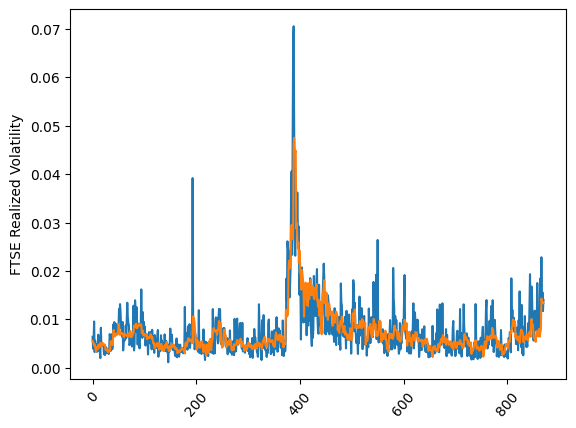

In [62]:
plt.plot(range(len(Y_true)), Y_true)
plt.plot(range(len(Y_true)), Y_hat1) 
plt.ylabel("FTSE Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [76]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast with PH': Y_hat1
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast with PH (NBEATSx).csv")